In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.api import tsa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=100

2024-03-05 16:06:28.375505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data set
df = pd.read_csv('TSLA.csv',parse_dates=['Date'])

# set 'Date' column as index
df.set_index('Date',inplace=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [4]:
# assign target feature
target = df['Adj Close']

# create data frame only contains target variable
df = pd.DataFrame(target)

df.head()

,Adj Close
Date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


# Preprocessing 

## Train-Test Split

For time series models, the sequential split method is particularly suitable for the models. In this approach, data points are split in chronological order rather than randomly, preserving the temporal sequence essential for time series analysis.

Since we are implementing GRU to the model, the model requires our data to be transformed into sequenses that can be fed into the GRU layer. Each sequence contains a fixed number of timesteps representing the prices at previous times, and the model learns to predict the price at the next timestep. 

As we saw earlier, there is great volatility to the closing price, the model would perform better if we set a smaller window of period. For this project, I will set 7 days as the number of days for the model to look back. each input sequence would contain data from the past 7 days, and each corresponding output should be the price we want to predict.

In [5]:
# split the data into 80% train and 20% test
split_point_train = int(len(df)*0.8)


train = df.iloc[:split_point_train]
remainder = df.iloc[split_point_train-7:]


# split remainder into validation and test
split_point_validation = int(len(remainder) * 0.5)
validation = remainder.iloc[:split_point_validation]
test = remainder.iloc[split_point_validation-7:]

In [6]:
# check shape
print(f"The shape of train set is {train.shape}, the shape of validation set is {validation.shape}, the shape of test set is {test.shape}.")

The shape of train set is (2364, 1), the shape of validation set is (299, 1), the shape of test set is (307, 1).


## Normalization

Normalize the data after the train-test-split to avoid data leakage.

In [7]:
# instantiate MinMaxScaler
minmax = MinMaxScaler()

# fit and transform
train_scaled = minmax.fit_transform(train)
validation_scaled = minmax.transform(validation)
test_scaled = minmax.transform(test)


# put transformed arrays back to the dataframe
train = pd.DataFrame(train_scaled,columns=train.columns,index=train.index)
validation = pd.DataFrame(validation_scaled,columns=validation.columns,index=validation.index)
test = pd.DataFrame(test_scaled,columns=test.columns,index=test.index)

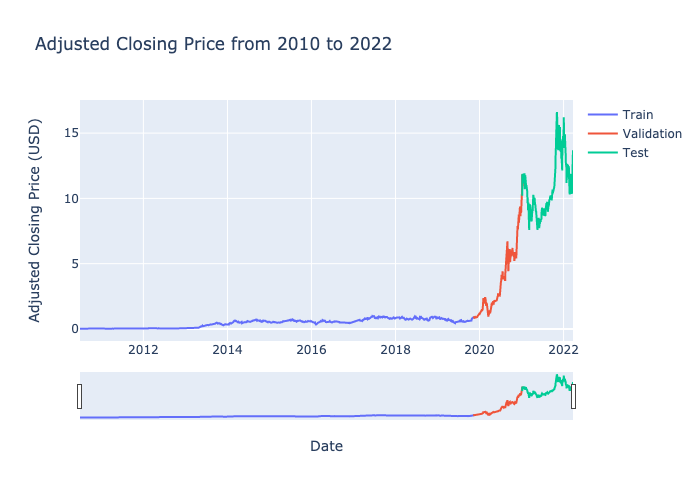

In [8]:
# visualize

fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train['Adj Close'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=validation.index, y=validation['Adj Close'], mode='lines', name="Validation"))
fig.add_trace(go.Scatter(x=test.index, y=test['Adj Close'], mode='lines', name="Test"))
fig.update_layout(
    yaxis_title="Adjusted Closing Price (USD)", 
    xaxis_title="Date",
    title="Adjusted Closing Price from 2010 to 2022"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

# LSTM

In [9]:
# create sequences from the time series data that we will use to train the LSTM

X_train = []
y_train = []

for i in range(7, len(train_scaled)):

    X_train.append(train_scaled[i-7:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# do the same for the validation set
X_validation = []
y_validation = []

for i in range(7, len(validation_scaled)):

    X_validation.append(validation_scaled[i-7:i, 0])
    y_validation.append(validation_scaled[i, 0])
    
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

# do the same for the test set
X_test = []
y_test = []

for i in range(7, len(test_scaled)):

    X_test.append(test_scaled[i-7:i, 0])
    y_test.append(test_scaled[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

The GRU model is trained on time sequences, learning the underlying patterns in the historical stock prices. The update and reset gates within the GRU units allow the model to learn which information is relevant for making predictions and which can be ignored, helping it to capture both short-term and long-term dependencies in the data.

In [10]:
lstm = Sequential([
    LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    GRU(50, return_sequences = False),
    Dense(25),
    Dense(1)
        ])

lstm.compile(optimizer=Adam(learning_rate=0.00001),loss='mse',metrics='mae')

In [11]:
history = lstm.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_validation, y_validation), shuffle=False)

Epoch 1/100
148/148 [==============================] - 6s 11ms/step - loss: 0.2824 - mae: 0.4407 - val_loss: 20.8692 - val_mae: 3.7177
Epoch 2/100
148/148 [==============================] - 1s 5ms/step - loss: 0.1955 - mae: 0.3626 - val_loss: 18.5627 - val_mae: 3.4529
Epoch 3/100
148/148 [==============================] - 1s 6ms/step - loss: 0.1322 - mae: 0.3069 - val_loss: 16.4457 - val_mae: 3.1917
Epoch 4/100
148/148 [==============================] - 1s 6ms/step - loss: 0.0833 - mae: 0.2526 - val_loss: 14.4966 - val_mae: 2.9322
Epoch 5/100
148/148 [==============================] - 1s 6ms/step - loss: 0.0493 - mae: 0.2012 - val_loss: 12.8009 - val_mae: 2.6886
Epoch 6/100
148/148 [==============================] - 1s 6ms/step - loss: 0.0297 - mae: 0.1581 - val_loss: 11.4535 - val_mae: 2.4808
Epoch 7/100
148/148 [==============================] - 1s 6ms/step - loss: 0.0206 - mae: 0.1272 - val_loss: 10.4791 - val_mae: 2.3226
Epoch 8/100
148/148 [==============================] - 1s 6ms

148/148 [==============================] - 1s 9ms/step - loss: 8.8728e-04 - mae: 0.0200 - val_loss: 6.1838 - val_mae: 1.5683
Epoch 62/100
148/148 [==============================] - 1s 9ms/step - loss: 8.8610e-04 - mae: 0.0200 - val_loss: 6.1879 - val_mae: 1.5692
Epoch 63/100
148/148 [==============================] - 1s 9ms/step - loss: 8.8491e-04 - mae: 0.0200 - val_loss: 6.1918 - val_mae: 1.5701
Epoch 64/100
148/148 [==============================] - 1s 9ms/step - loss: 8.8373e-04 - mae: 0.0199 - val_loss: 6.1955 - val_mae: 1.5710
Epoch 65/100
148/148 [==============================] - 1s 9ms/step - loss: 8.8255e-04 - mae: 0.0199 - val_loss: 6.1991 - val_mae: 1.5719
Epoch 66/100
148/148 [==============================] - 1s 9ms/step - loss: 8.8136e-04 - mae: 0.0199 - val_loss: 6.2025 - val_mae: 1.5727
Epoch 67/100
148/148 [==============================] - 1s 9ms/step - loss: 8.8018e-04 - mae: 0.0199 - val_loss: 6.2058 - val_mae: 1.5735
Epoch 68/100
148/148 [=========================

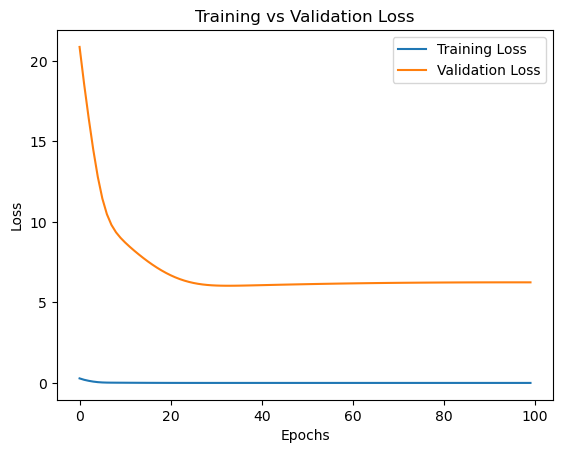

In [39]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

The training loss stays relatively flat around 0, and there is a significant and consistent gap between the training and validation losses. After 60 epochs, the validation loss started to diverge from the training loss suggests overfitting.

In [13]:
# predict
predictions = lstm.predict(X_validation)

#inverse predictions scaling
predictions = minmax.inverse_transform(predictions)
predictions.shape

10/10 [==============================] - 1s 5ms/step


(292, 1)

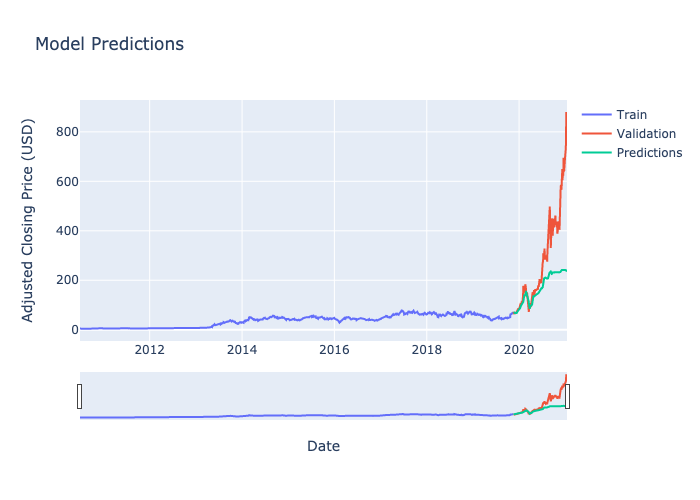

In [14]:
# visualize the predictions
train = df.iloc[ :split_point_train,0:1]
validation = df.iloc[split_point_train:split_point_train+split_point_validation-7,0:1]
validation['Predictions'] = predictions

fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train['Adj Close'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=validation.index, y=validation['Adj Close'], mode='lines', name="Validation"))
fig.add_trace(go.Scatter(x=validation.index,y=validation['Predictions'],mode='lines', name="Predictions"))
fig.update_layout(
    yaxis_title="Adjusted Closing Price (USD)", 
    xaxis_title="Date",
    title="Model Predictions"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

In [15]:
# inverse y_test scale
y_validation = minmax.inverse_transform([y_validation])

In [16]:
# get RMSE for evaluation
rmse = np.sqrt(np.mean(y_validation-predictions)**2).round(2)
print(f'The model RMSE is:{rmse}.')

The model RMSE is:115.71.


Initially, the model seems to capture the upward trend observed in the test data. However, it underestimates the magnitude of the increase after April 2020, and started to diverge from the test data especially during periods of rapid price growth.

Financial markets evolve over time due to changes in economic conditions, investor behavior, regulatory environments, and other factors. A model trained on the most recent data may better capture current market dynamics and trends, making it more relevant and accurate for forecasting short-term future prices. Recall the overall trend of the Tesla's stock price, the adjusted closing price stayed very stable from 2010 to mid 2013, I will select a more specific time frame where volatility is present to train the model again and see if the model's performance would improve.

I will set the cut off time to May 2013 first.

## LSTM (2013-05-01 to 2022-03-24)

In [17]:
# specify the new time frame to 2013-05-01 onward
df1 = df[df.index>='2013-05-01']

# split the data into 80% train and 20% test
split_point_train1 = int(len(df1)*0.8)


train1 = df1.iloc[:split_point_train1]
remainder1 = df1.iloc[split_point_train1-7:]


# split remainder into validation and test
split_point_validation1 = int(len(remainder1) * 0.5)
validation1 = remainder1.iloc[:split_point_validation1]
test1 = remainder1.iloc[split_point_validation1-7:]

In [18]:
# instantiate MinMaxScaler
minmax1 = MinMaxScaler()

# scaling the data
train_scaled1 = minmax1.fit_transform(train1)
validation_scaled1 = minmax1.transform(validation1)
test_scaled1 = minmax1.transform(test1)

In [19]:
# create sequences from the time series data that we will use to train the LSTM
X_train1 = []
y_train1 = []

for i in range(7, len(train_scaled1)):

    X_train1.append(train_scaled1[i-7:i, 0])
    y_train1.append(train_scaled1[i, 0])
    
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

# do the same for the validation set
X_validation1 = []
y_validation1 = []

for i in range(7, len(validation_scaled1)):
    
    X_validation1.append(validation_scaled1[i-7:i, 0])
    y_validation1.append(validation_scaled1[i,0])
    
X_validation1, y_validation1 = np.array(X_validation1), np.array(y_validation1)

# do the same for the test set
X_test1 = []
y_test1 = []

for i in range(7, len(test_scaled1)):

    X_test1.append(test_scaled1[i-7:i, 0])
    y_test1.append(test_scaled1[i,0])
    
X_test1, y_test1 = np.array(X_test1), np.array(y_test1)


X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

In [20]:
# instantiate LSTM model with GRU layer

lstm1 = Sequential([
    LSTM(50, return_sequences = True, input_shape = (X_train1.shape[1], 1)),
    GRU(50, return_sequences = False),
    Dense(25),
    Dense(1)
        ])

# compile the model
lstm1.compile(optimizer=Adam(learning_rate=0.00001),loss='mse',metrics='mae')

In [21]:
# train the model
history1 = lstm1.fit(X_train1, y_train1, batch_size=16, epochs=100, validation_data=(X_validation1, y_validation1), shuffle=False)

Epoch 1/100
112/112 [==============================] - 10s 26ms/step - loss: 0.0543 - mae: 0.2032 - val_loss: 7.0265 - val_mae: 2.4727
Epoch 2/100
112/112 [==============================] - 1s 11ms/step - loss: 0.0337 - mae: 0.1466 - val_loss: 6.2685 - val_mae: 2.3264
Epoch 3/100
112/112 [==============================] - 1s 12ms/step - loss: 0.0224 - mae: 0.1079 - val_loss: 5.6471 - val_mae: 2.1996
Epoch 4/100
112/112 [==============================] - 1s 12ms/step - loss: 0.0154 - mae: 0.0783 - val_loss: 5.1346 - val_mae: 2.0898
Epoch 5/100
112/112 [==============================] - 1s 13ms/step - loss: 0.0115 - mae: 0.0608 - val_loss: 4.7214 - val_mae: 1.9973
Epoch 6/100
112/112 [==============================] - 1s 11ms/step - loss: 0.0096 - mae: 0.0556 - val_loss: 4.3936 - val_mae: 1.9212
Epoch 7/100
112/112 [==============================] - 1s 11ms/step - loss: 0.0087 - mae: 0.0556 - val_loss: 4.1327 - val_mae: 1.8589
Epoch 8/100
112/112 [==============================] - 1s 11m

112/112 [==============================] - 1s 10ms/step - loss: 5.8795e-04 - mae: 0.0133 - val_loss: 0.3209 - val_mae: 0.4286
Epoch 62/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8785e-04 - mae: 0.0133 - val_loss: 0.3195 - val_mae: 0.4276
Epoch 63/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8772e-04 - mae: 0.0133 - val_loss: 0.3183 - val_mae: 0.4267
Epoch 64/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8758e-04 - mae: 0.0133 - val_loss: 0.3173 - val_mae: 0.4259
Epoch 65/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8742e-04 - mae: 0.0133 - val_loss: 0.3163 - val_mae: 0.4252
Epoch 66/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8724e-04 - mae: 0.0133 - val_loss: 0.3154 - val_mae: 0.4246
Epoch 67/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8705e-04 - mae: 0.0133 - val_loss: 0.3146 - val_mae: 0.4240
Epoch 68/100
112/112 [==================

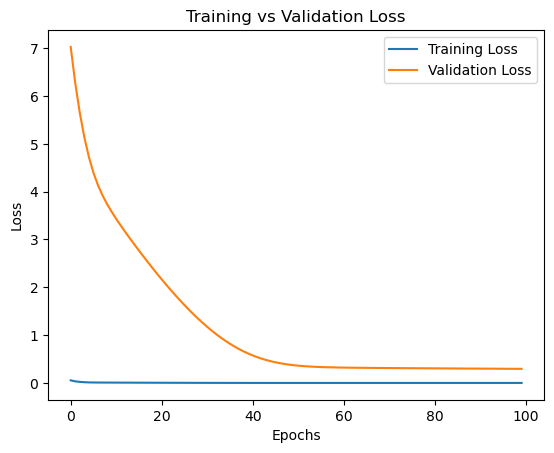

In [22]:
# plot the model losses

training_loss1 = history1.history['loss']
validation_loss1 = history1.history['val_loss']

plt.plot(training_loss1, label='Training Loss')
plt.plot(validation_loss1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

The training loss still stays at 0, but the validation loss stopped diverging from the training loss.

In [23]:
# predict
predictions1 = lstm1.predict(X_validation1)

#inverse predictions scaling
predictions1 = minmax1.inverse_transform(predictions1)
predictions1.shape

7/7 [==============================] - 1s 4ms/step


(221, 1)

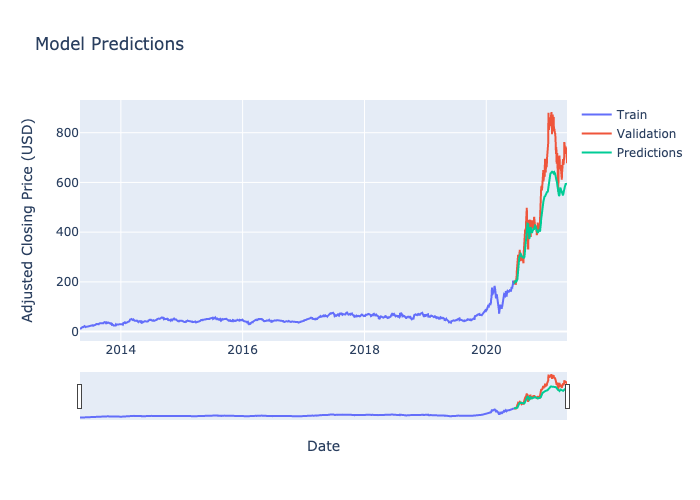

In [24]:
# visualize the predictions
train1 = df1.iloc[ :split_point_train1,0:1]
validation1 = df1.iloc[split_point_train1:split_point_train1+split_point_validation1-7,0:1]
validation1['Predictions'] = predictions1

fig = go.Figure()

fig.add_trace(go.Scatter(x=train1.index, y=train1['Adj Close'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=validation1.index, y=validation1['Adj Close'], mode='lines', name="Validation"))
fig.add_trace(go.Scatter(x=validation1.index,y=validation1['Predictions'],mode='lines', name="Predictions"))
fig.update_layout(
    yaxis_title="Adjusted Closing Price (USD)", 
    xaxis_title="Date",
    title="Model Predictions"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

In [25]:
# inverse y_test scale
y_validation1  = minmax1.inverse_transform([y_validation1])

In [26]:
# get RMSE for evaluation
rmse1 = np.sqrt(np.mean(y_validation1-predictions1)**2).round(2)
print(f'The model RMSE is: {rmse1}.')

The model RMSE is: 74.73.


Although the RMSE increased from 115.71 to 74.73, but the new model performs much better already, we can see the predictions follow the trend of the test data very well and successfully captured the fluctuations happened around August 2020 and January 2021, but the magnitude of the predictions fall short to the actual prices. 

Let's set the time frame even smaller for the model to capture information happening during the more current years.

## LSTM (2019-11-01 to 2022-03-24)

In [27]:
# specify the new time frame to 2019-11-01 onward
df2 = df[df.index>='2019-11-01']

# split the data into 80% train and 20% test
split_point_train2 = int(len(df2)*0.8)


train2 = df2.iloc[:split_point_train2]
remainder2 = df2.iloc[split_point_train2-7:]


# split remainder into validation and test
split_point_validation2 = int(len(remainder2) * 0.5)
validation2 = remainder2.iloc[:split_point_validation2]
test2 = remainder2.iloc[split_point_validation2-7:]


# instantiate MinMaxScaler
minmax2 = MinMaxScaler()
# fit and transform
train_scaled2 = minmax2.fit_transform(train2)
validation_scaled2 = minmax2.transform(validation2)
test_scaled2 = minmax2.transform(test2)

# put transformed arrays back to the dataframe
train2 = pd.DataFrame(train_scaled2,columns=train2.columns,index=train2.index)
validation2 = pd.DataFrame(validation_scaled2,columns=validation2.columns,index=validation2.index)
test2 = pd.DataFrame(test_scaled2,columns=test2.columns,index=test2.index)

# create sequences from the time series data that we will use to train the LSTM
X_train2 = []
y_train2 = []

for i in range(7, len(train_scaled2)):

    X_train2.append(train_scaled2[i-7:i, 0])
    y_train2.append(train_scaled2[i, 0])
    
X_train2, y_train2 = np.array(X_train2), np.array(y_train2)

# do the same for the validation set
X_validation2 = []
y_validation2 = []

for i in range(7, len(validation_scaled2)):

    X_validation2.append(validation_scaled2[i-7:i, 0])
    y_validation2.append(validation_scaled2[i,0])
    
X_validation2, y_validation2 = np.array(X_validation2), np.array(y_validation2)


# do the same for the test set
X_test2 = []
y_test2 = []

for i in range(7, len(test_scaled2)):

    X_test2.append(test_scaled2[i-7:i, 0])
    y_test2.append(test_scaled2[i,0])
    
X_test2, y_test2 = np.array(X_test2), np.array(y_test2)


X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))
X_validation2 = np.reshape(X_validation2, (X_validation2.shape[0], X_validation2.shape[1], 1))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))


# instantiate LSTM model with GRU layer
lstm2 = Sequential([
    LSTM(50, return_sequences = True, input_shape = (X_train2.shape[1], 1)),
    GRU(50, return_sequences = False),
    Dense(25),
    Dense(1)
        ])

# compile the model
lstm2.compile(optimizer=Adam(learning_rate=0.00005),loss='mse',metrics='mae')

# train the model33
history2 = lstm2.fit(X_train2, y_train2, batch_size=16, epochs=100, validation_data=(X_validation2, y_validation2), shuffle=False)

Epoch 1/100
30/30 [==============================] - 8s 54ms/step - loss: 0.1267 - mae: 0.2944 - val_loss: 0.4926 - val_mae: 0.6919
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0692 - mae: 0.2104 - val_loss: 0.3003 - val_mae: 0.5375
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 0.0351 - mae: 0.1558 - val_loss: 0.1709 - val_mae: 0.4013
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0182 - mae: 0.1181 - val_loss: 0.0945 - val_mae: 0.2928
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0119 - mae: 0.0973 - val_loss: 0.0563 - val_mae: 0.2191
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0102 - mae: 0.0882 - val_loss: 0.0392 - val_mae: 0.1768
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0093 - mae: 0.0830 - val_loss: 0.0314 - val_mae: 0.1537
Epoch 8/100
30/30 [==============================] - 0s 11ms/step - loss: 0.

30/30 [==============================] - 0s 11ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0717
Epoch 63/100
30/30 [==============================] - 0s 11ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0717
Epoch 64/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0716
Epoch 65/100
30/30 [==============================] - 0s 11ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0716
Epoch 66/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0716
Epoch 67/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0715
Epoch 68/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0085 - val_mae: 0.0715
Epoch 69/100
30/30 [==============================] - 0s 10ms/step - loss: 0.0014 

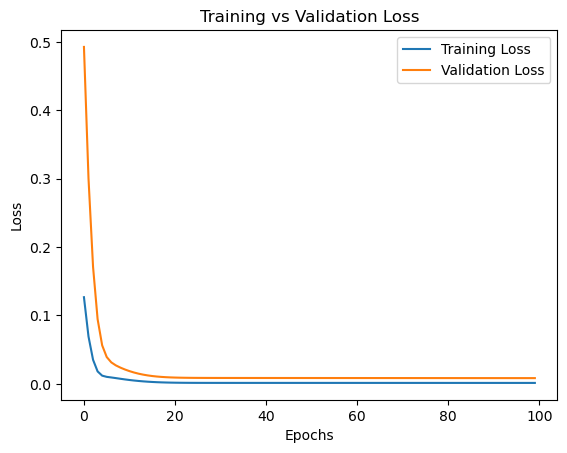

In [28]:
# plot the model losses
training_loss2 = history2.history['loss']
validation_loss2 = history2.history['val_loss']

plt.plot(training_loss2, label='Training Loss')
plt.plot(validation_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Both trainig and validation loss have a sharp drop in the early stage of trainig, the gap between two losses dramatically decreased.

In [29]:
# predict
predictions2 = lstm2.predict(X_validation2)

#inverse predictions scaling
predictions2 = minmax2.inverse_transform(predictions2)
predictions2.shape

2/2 [==============================] - 1s 6ms/step


(57, 1)

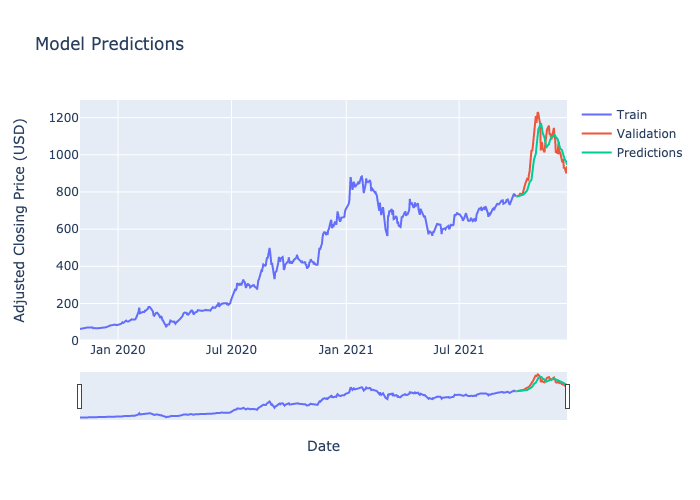

In [30]:
# visualize the predictions
train2 = df2.iloc[ :split_point_train2,0:1]
validation2 = df2.iloc[split_point_train2:split_point_train2+split_point_validation2-7,0:1]
validation2['Predictions'] = predictions2

fig = go.Figure()


fig.add_trace(go.Scatter(x=train2.index, y=train2['Adj Close'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=validation2.index, y=validation2['Adj Close'], mode='lines', name="Validation"))
fig.add_trace(go.Scatter(x=validation2.index,y=validation2['Predictions'],mode='lines', name="Predictions"))
fig.update_layout(
    yaxis_title="Adjusted Closing Price (USD)", 
    xaxis_title="Date",
    title="Model Predictions"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

In [31]:
# inverse y_test scale
y_validation2  = minmax2.inverse_transform([y_validation2])

In [32]:
# get RMSE for evaluation
rmse2 = np.sqrt(np.mean(y_validation2-predictions2)**2).round(2)
print(f'The model RMSE is: {rmse2}.')

The model RMSE is: 19.87.


Nice! The predictions follow the actual prices in the test set, mirroring major peaks and troughs. However, there are still instances where the predictions deviate from the actual prices, particularly around sharp rises and falls. The deviations contribute to the overall error measured by the RMSE. The Root Mean Square Error (RMSE) of 19.87 indicates that, on average, the model's predictions are approximately $19.87 away from the actual stock prices. Given the price scale on the y-axis, an RMSE of 19.87 can be considered relatively small, especially during periods where the stock price exhibits high volatility and large price swings.

2/2 [==============================] - 0s 6ms/step


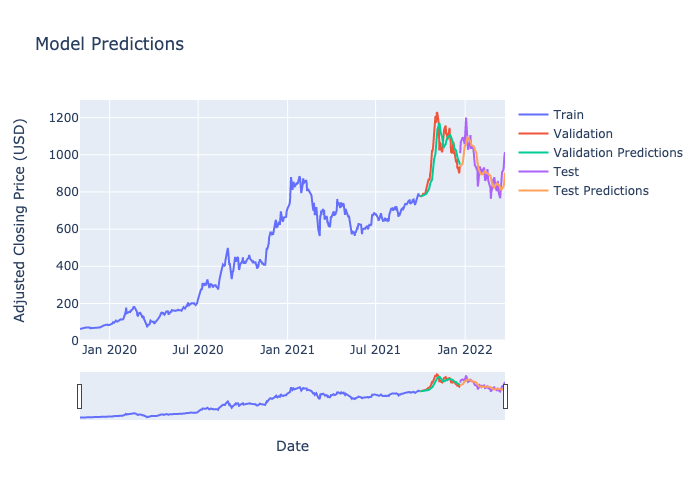

In [33]:
# look at the graph with test data and predictions

# predict on test
predictions_test2 = lstm2.predict(X_test2)

# inverse predictions scaling
predictions_test2 = minmax2.inverse_transform(predictions_test2)
predictions_test2.shape


# visualize the predictions
train2 = df2.iloc[ :split_point_train2,0:1]
validation2 = df2.iloc[split_point_train2:split_point_train2+split_point_validation2-7,0:1]
test2 = df2.iloc[split_point_train2+split_point_validation2-7:,0:1]
validation2['Predictions'] = predictions2
test2['Predictions'] = predictions_test2


fig = go.Figure()

fig.add_trace(go.Scatter(x=train2.index, y=train2['Adj Close'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=validation2.index, y=validation2['Adj Close'], mode='lines', name="Validation"))
fig.add_trace(go.Scatter(x=validation2.index,y=validation2['Predictions'],mode='lines', name="Validation Predictions"))
fig.add_trace(go.Scatter(x=test2.index, y=test2['Adj Close'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=test2.index,y=test2['Predictions'],mode='lines', name="Test Predictions"))
fig.update_layout(
    yaxis_title="Adjusted Closing Price (USD)", 
    xaxis_title="Date",
    title="Model Predictions"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show('png')

The model seems capable of capturing both the trend and, to some extent, the volatility of the closing price. The predictions on the test captures the general trend and volatility, which is crucial for confirming that the model can perform well on unseen data.

Despite the overall good performance, careful attention should be given to any small deviations, especially if the model predictions start to consistently lag behind or overshoot actual values. This isn't evident in the provided graph but is something to monitor with a more granular analysis. The excellent alignment between predictions and actual values in both validation and test phases suggests that overfitting is likely not a concern here, assuming the validation and test sets are appropriately challenging and representative of the problem space.

# Predict Consecutive Price into the Next 90 Days

In [34]:
# create function to prepare the input for the next forecast by shifting the window of input data
def insert_end(X_future, new_input):
    
    timestep = 7
    
    # shift the past predictions to the left by one timestep
    for i in range(timestep - 1):
        X_future[:, i, :] = X_future[:, i+1, :]
    
    # insert the most recent future data at the end of the array to use as input for the next prediction
    X_future[:, timestep - 1, :] = new_input
    return X_future

In [35]:
# 90 days to predict into the future
future = 90
# list to store the predictions 
forecast = []
X_future = X_test2[-1 :, :, :]
time = []

# loop to generate future predictions
for i in range(0, future):
    # predict the next value using the current input
    predictions_future = lstm2.predict(X_future, batch_size=32)
    forecast.append(predictions_future[0, 0]) 
    
    print(forecast)
    
    # update the input data with the new predictions
    X_future = insert_end(X_future, predictions_future[0, 0]) 
    # append generated datetime in 'time' list
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 32ms/step
[1.0257143]
1/1 [==============================] - 0s 30ms/step
[1.0257143, 1.0471169]
1/1 [==============================] - 0s 32ms/step
[1.0257143, 1.0471169, 1.0587151]
1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647]
1/1 [==============================] - 0s 30ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291]
1/1 [==============================] - 0s 30ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101]
1/1 [==============================] - 0s 30ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366]
1/1 [==============================] - 0s 30ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395]
1/1 [==============================] - 0s 30ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204]
1/1 [=============================

1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244995, 1.0233495, 1.0222125, 1.0210882]
1/1 [==============================] - 0s 36ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244995, 1.0233495, 1.0222125, 1.0210882, 1.0199757]
1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.058

1/1 [==============================] - 0s 43ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244995, 1.0233495, 1.0222125, 1.0210882, 1.0199757, 1.0188752, 1.017787, 1.0167105, 1.015646, 1.0145929, 1.0135514, 1.012521, 1.0115018, 1.0104935, 1.009496, 1.0085092, 1.0075328, 1.0065668, 1.0056111, 1.0046654]
1/1 [==============================] - 0s 32ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244

1/1 [==============================] - 0s 33ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244995, 1.0233495, 1.0222125, 1.0210882, 1.0199757, 1.0188752, 1.017787, 1.0167105, 1.015646, 1.0145929, 1.0135514, 1.012521, 1.0115018, 1.0104935, 1.009496, 1.0085092, 1.0075328, 1.0065668, 1.0056111, 1.0046654, 1.0037297, 1.0028039, 1.0018878, 1.0009813, 1.0000842, 0.9991964, 0.99831796, 0.99744844, 0.9965881, 0.9957365, 0.99489367, 0.99405956, 0.993234]
1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 

1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244995, 1.0233495, 1.0222125, 1.0210882, 1.0199757, 1.0188752, 1.017787, 1.0167105, 1.015646, 1.0145929, 1.0135514, 1.012521, 1.0115018, 1.0104935, 1.009496, 1.0085092, 1.0075328, 1.0065668, 1.0056111, 1.0046654, 1.0037297, 1.0028039, 1.0018878, 1.0009813, 1.0000842, 0.9991964, 0.99831796, 0.99744844, 0.9965881, 0.9957365, 0.99489367, 0.99405956, 0.993234, 0.99241674, 0.99160784, 0.9908072, 0.9900147, 0.9892301, 0.98845345, 0.9876847, 0.98692364, 0.9861703, 0.9854245, 0.9846859]
1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585

1/1 [==============================] - 0s 31ms/step
[1.0257143, 1.0471169, 1.0587151, 1.064647, 1.0662291, 1.0661101, 1.0585366, 1.0511395, 1.0539204, 1.0540109, 1.052839, 1.0510848, 1.0491619, 1.0471971, 1.0458031, 1.0448937, 1.0435705, 1.0421348, 1.0407045, 1.039325, 1.0380039, 1.0367402, 1.0354838, 1.034198, 1.0329249, 1.0316738, 1.0304438, 1.0292313, 1.028032, 1.0268425, 1.0256639, 1.0244995, 1.0233495, 1.0222125, 1.0210882, 1.0199757, 1.0188752, 1.017787, 1.0167105, 1.015646, 1.0145929, 1.0135514, 1.012521, 1.0115018, 1.0104935, 1.009496, 1.0085092, 1.0075328, 1.0065668, 1.0056111, 1.0046654, 1.0037297, 1.0028039, 1.0018878, 1.0009813, 1.0000842, 0.9991964, 0.99831796, 0.99744844, 0.9965881, 0.9957365, 0.99489367, 0.99405956, 0.993234, 0.99241674, 0.99160784, 0.9908072, 0.9900147, 0.9892301, 0.98845345, 0.9876847, 0.98692364, 0.9861703, 0.9854245, 0.9846859, 0.9839551, 0.9832311, 0.9825147, 0.98180515, 0.9811027, 0.98040724, 0.97971857, 0.9790365, 0.9783614]
1/1 [=================

In [36]:
next_90 = np.array(forecast)
# reshape the forecast dat for plotting
next_90 = np.array(forecast).reshape(-1, 1)
next_90 = minmax2.inverse_transform(next_90) 

next_90 = pd.DataFrame(next_90)

# convert time list to datetime format
date = pd.DataFrame(time)

# concat two dataframes
future_months = pd.concat([date, next_90], axis = 1)
future_months.columns = 'Date', 'Adj Close'

future_months.head()

,Date,Adj Close
0,2022-03-24,904.186707
1,2022-03-25,921.745972
2,2022-03-26,931.261475
3,2022-03-27,936.128174
4,2022-03-28,937.426208


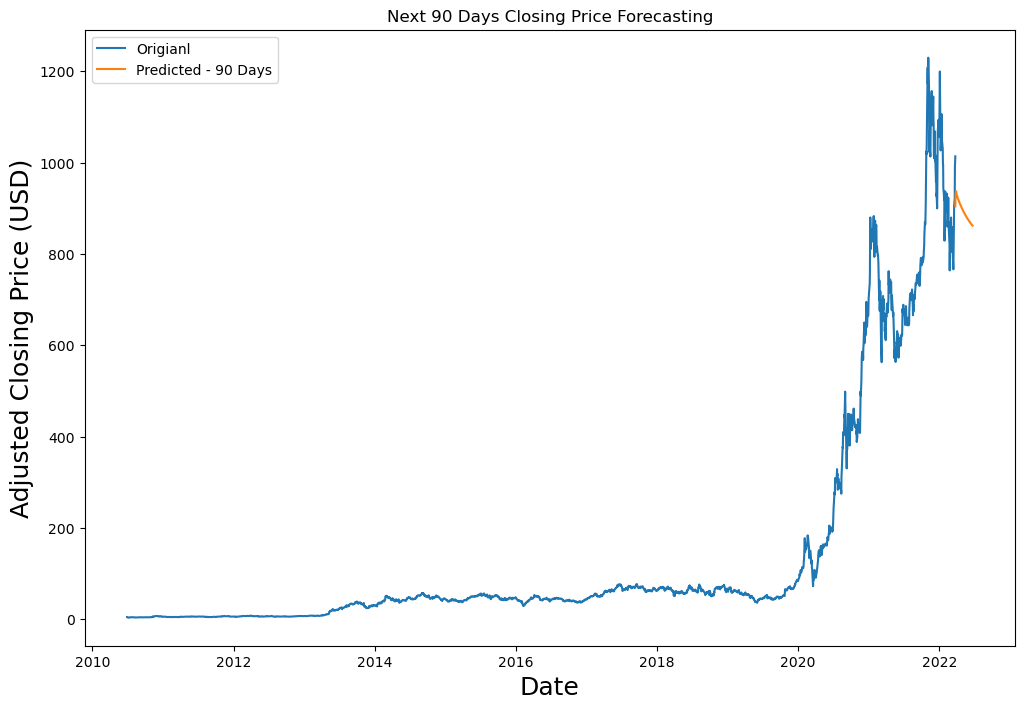

In [44]:
# visualize
plt.figure(figsize=(12, 8))

plt.plot(df['Adj Close'],label='Origianl')
plt.plot(future_months.set_index('Date')[['Adj Close']],label='Predicted - 90 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (USD)' ,fontsize=18)
plt.title('Next 90 Days Closing Price Forecasting')
plt.legend()

plt.show()